<a href="https://colab.research.google.com/github/kmenesesrivera/codonusagebias/blob/main/2-Comparaci%C3%B3n_de_Modelos_Selecci%C3%B3n_de_Caracteristicas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Comparación de Modelos  

###Lectura de la Data

In [6]:
import urllib.request
import zipfile, urllib.request, shutil
from __future__ import absolute_import, division, print_function, unicode_literals

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00577/codon_usage.csv.zip'
filename = 'codon_usage.csv.zip'

In [8]:
with urllib.request.urlopen(url) as response, open(filename, 'wb') as out_file:
    shutil.copyfileobj(response, out_file)
    with zipfile.ZipFile(filename) as zf:
        zf.extractall()

In [9]:
!unzip codon_usage.csv

Archive:  codon_usage.csv
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
Archive:  codon_usage.csv.zip
replace codon_usage.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier 
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
import tensorflow.python.keras, math
from sklearn.model_selection import train_test_split
labelencoder = LabelEncoder()

In [2]:
#Lectura del dataset
file_name = "codon_usage.csv"
dataset = pd.read_csv(file_name,  header=None)
# Eliminando columnas inválidas
columns = dataset.iloc[0]
dataset.columns = columns
dataset = dataset.drop([0],axis=0)

cols = dataset.columns[dataset.dtypes.eq(object)] # Seleccionamos las columnas con el tipo de datao : Object
dataset = dataset[cols].apply(pd.to_numeric, errors='ignore') #se transforma

# Se observa que hay datos str que no permiten manipular los demás como numéricos, por lo tanto se va a forzar.
dataset[['UUU', 'UUC']] = dataset[['UUU', 'UUC']].apply(pd.to_numeric, errors='coerce')
null_percentages = dataset['UUU'].isna().sum()
null_percentages



FileNotFoundError: ignored

In [ ]:
def preprocess_dataset(dataset, save_metadata=True):
  
  preprocessed_dataset = dataset.copy()

  #Determinamos aquellas variables que tengan un porcentaje de registros únicos por cada variable mayor al valor de 0.7
  threshold = 0.7

  unique_percentages = dataset.nunique() / len(dataset)

  criteria = unique_percentages > threshold

  columns_to_filter = unique_percentages[criteria].keys()
  
  # Está columna contiene datos descriptivos, por tanto será transformada a str.

  preprocessed_dataset['SpeciesName'] = preprocessed_dataset['SpeciesName'].astype(str)
  preprocessed_dataset['SpeciesName']
 
  #Eliminamos las variables seleccionadas en el paso anterior
  preprocessed_dataset.drop(columns_to_filter, axis=1, inplace=True)
 
  #Eliminamos los registros duplicados
  preprocessed_dataset.drop_duplicates(keep="first", inplace=True)

  #Determinamos que variables son del tipo númerico y cuales son categóricas
  numeric_columns = list()
  categorical_columns = list()
  dictionary_of_columns_with_index_to_categorical = dict()
  dictionary_of_columns_with_categorical_to_index = dict()

  for column in preprocessed_dataset:
    #Determinamos si la variable es numérica o no
    if pd.api.types.is_numeric_dtype(preprocessed_dataset[column]):
      numeric_columns.append(column)
    else:
      #Modificamos el tipo de dato de la variable mediante "astype"
      preprocessed_dataset[column] = preprocessed_dataset[column].astype("category")

      #Verificamos si el tipo de dato de la variable fue transformado a categórico correctamente
      if not pd.api.types.is_categorical_dtype(preprocessed_dataset[column]):
        raise Exception("La columna {} no se transformó correctamente a categórica".format(column))

      dictionary_of_columns_with_index_to_categorical[column] = dict()
      dictionary_of_columns_with_categorical_to_index[column] = dict()
      
      #Indexamos los valores (categorías), sin tomar en consideración los nulos, de la variable y guardamos esa información en los diccionarios
      for index, category in enumerate(preprocessed_dataset[column].cat.categories):
        dictionary_of_columns_with_index_to_categorical[column][index] = category
        dictionary_of_columns_with_categorical_to_index[column][category] = index
      
      categorical_columns.append(column)
  
  #Reemplazamos los nulos con la mediana sólo de aquellas variables numéricas
    median_of_numeric_columns = preprocessed_dataset[numeric_columns].median()
    preprocessed_dataset[numeric_columns] = preprocessed_dataset[numeric_columns].fillna(median_of_numeric_columns)

  #Transformamos a números los valores (categorías) de las variables categóricas sin considerar los nulos
  preprocessed_dataset.replace(dictionary_of_columns_with_categorical_to_index, inplace=True)

  #Determinamos aquellas variables que tengan un porcentaje de registros nulos por cada variable mayor al valor de 0.7
  threshold = 0.7

  null_percentages = preprocessed_dataset[categorical_columns].isna().sum() / len(preprocessed_dataset)

  criteria = null_percentages > threshold

  columns_to_filter = null_percentages[criteria].keys()

  #Eliminamos las variables seleccionadas en el paso anterior
  preprocessed_dataset.drop(columns_to_filter, axis=1, inplace=True)

  #Eliminamos los registros duplicados
  preprocessed_dataset.drop_duplicates(keep="first", inplace=True)
 
  return preprocessed_dataset

In [ ]:
preprocessed_dataset = preprocess_dataset(dataset)


In [ ]:
preprocessed_dataset.describe

<bound method NDFrame.describe of 0      Kingdom  DNAtype   Ncodons      UUU  ...      GAG      UAA      UAG      UGA
1            9        0      1995  0.01654  ...  0.04361  0.00251  0.00050  0.00000
2            9        0      1474  0.02714  ...  0.04410  0.00271  0.00068  0.00000
3            9        0      4862  0.01974  ...  0.02468  0.00391  0.00000  0.00144
4            9        0      1915  0.01775  ...  0.03446  0.00261  0.00157  0.00000
5            9        0     22831  0.02816  ...  0.03679  0.00000  0.00044  0.00131
...        ...      ...       ...      ...  ...      ...      ...      ...      ...
13024        7        0      1097  0.02552  ...  0.04102  0.00091  0.00091  0.00638
13025        7        1      2067  0.01258  ...  0.00677  0.00242  0.00097  0.01887
13026        7        1      1686  0.01423  ...  0.00297  0.00356  0.00119  0.02017
13027        7        0  40662582  0.01757  ...  0.03959  0.00099  0.00079  0.00156
13028        7        1   8998998  0.01778

In [ ]:
#Separamos las columnas  Reino y ADN  , respectivamente.
X1 = preprocessed_dataset.drop("Kingdom", axis=1)
X2 = preprocessed_dataset.drop("DNAtype", axis=1)
Y1 = preprocessed_dataset["Kingdom"]  
Y2 = preprocessed_dataset["DNAtype"] 

In [ ]:
#Mediante el método "train_test_split" usaremos el 20% de la data para probar el modelo. El parámetro "random state" nos sirve para
#poder replicar la misma separación
x_train, Xt, y_train, Yt = train_test_split(X1, Y1, test_size=0.2, random_state=70)

In [ ]:
#Mediante el método "train_test_split" usaremos el 20% de la data para probar el modelo. El parámetro "random state" nos sirve para
#poder replicar la misma separación
x2_train, Xt2, y2_train, Yt2 = train_test_split(X2, Y2, test_size=0.2, random_state=70)

Ahora vamos a probar los modelos sin tunearlos

##Decision Tree

**Y1**

In [ ]:
dt = DecisionTreeClassifier()
dt.fit(x_train, y_train) #Entrenamos un Decision Tree tunear

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
f1_score(Yt, dt.predict(Xt), average='weighted') #Usamos F1 para comparar con otros modelos

0.7714955449405004

**Y2**

In [ ]:
dt2 = DecisionTreeClassifier()
dt2.fit(x2_train, y2_train) #Entrenamos un Decision Tree tunear

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
f1_score(Yt2, dt2.predict(Xt2), average='weighted') #Usamos F1 para comparar con otros modelos

0.974913794959661

##Random Forest

**Y1**

In [ ]:
rf = RandomForestClassifier(40, n_jobs=-1, oob_score=True)
rf.fit(x_train, y_train) #Entrenamos un Random Forest sin tunear

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
                       oob_score=True, random_state=None, verbose=0,
                       warm_start=False)

In [ ]:
f1_score(Yt, rf.predict(Xt), average='weighted') #Usamos F1 para comparar con otros modelos

0.8747286125156047

**Y2**

In [ ]:
rf2 = RandomForestClassifier(40, n_jobs=-1, oob_score=True)
rf2.fit(x2_train, y2_train) #Entrenamos un Random Forest sin tunear

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
                       oob_score=True, random_state=None, verbose=0,
                       warm_start=False)

In [ ]:
f1_score(Yt2, rf2.predict(Xt2), average='weighted') #Usamos F1 para comparar con otros modelos

0.9880422316034267

##Clasificador K-Nearest Neighbor

**Y1**

In [ ]:
n_neighbors = 4

knn = KNeighborsClassifier(n_neighbors)
knn.fit(x_train, y_train) #Entrenamos un KNN sin tunear

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='uniform')

In [ ]:
f1_score(Yt, knn.predict(Xt), average='weighted') #Usamos F1 para comparar con otros modelos

0.37425189253279567

**Y2**

In [ ]:
n_neighbors = 4

knn2 = KNeighborsClassifier(n_neighbors)
knn2.fit(x2_train, y2_train) #Entrenamos un KNN sin tunear

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='uniform')

In [ ]:
f1_score(Yt2, knn2.predict(Xt2), average='weighted') #Usamos F1 para comparar con otros modelos

0.7578392501379395

# Clasificador XGBost

**Y1**

In [ ]:
 xgb=XGBClassifier(n_estimators=80,  max_depth=10)
 xgb.fit(x_train, y_train) #Entrenamos un XGBost sin tunear


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=80, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
f1_score(Yt, xgb.predict(Xt), average='weighted') #Usamos F1 para comparar con otros modelos

0.9017597020186107

**Y2**

In [ ]:
xgb2=XGBClassifier(n_estimators=80, max_depth=10 )
xgb2.fit(x2_train, y2_train) #Entrenamos un XGBost sin tunear


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=80, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
f1_score(Yt2, xgb.predict(Xt2), average='weighted') #Usamos F1 para comparar con otros modelos

ValueError: ignored

# Clasificador LightGBM

**Y1**

In [ ]:
mdl = lgb.LGBMClassifier(boosting_type='gbdt',objective='binary')
mdl.fit(x_train, y_train) #Entrenamos un LightGBM sin tunear

In [ ]:
f1_score(Yt, mdl.predict(Xt), average='weighted') #Usamos F1 para comparar con otros modelos

**Y2**

In [ ]:
mdl2 = lgb.LGBMClassifier(boosting_type='gbdt',objective='binary',max_depth = 10)
mdl2.fit(x2_train, y2_train) #Entrenamos un XGBost sin tunear

In [ ]:
f1_score(Yt2, mdl2.predict(Xt2), average='weighted') #Usamos F1 para comparar con otros modelos

# Redes neuronales

In [ ]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer, MultiLabelBinarizer
import tensorflow as tf
dataset = pd.read_csv('https://drive.google.com/uc?export=download&id=1Z4v43cvTwp920NyOdboDKP7_ytC_0tBC')
dataset

In [ ]:
def ML_prepocess(data): 
  ml_data = data.copy()
  ml_data.Kingdom = ml_data.Kingdom.astype('category')
  drop_col = ['SpeciesID','SpeciesName','Ncodons']
  print("Columnas eliminadas:", drop_col)
  ml_data.drop(drop_col,inplace=True, axis=1)

  ml_data[['UUU', 'UUC']] = ml_data[['UUU', 'UUC']].apply(pd.to_numeric, errors='coerce')
  criteria = ~ml_data.isna()
  ml_data = ml_data[criteria['UUU']]
  ml_data = ml_data[criteria['UUC']]
  return ml_data

In [ ]:
ml_data = ML_prepocess(dataset)
ml_data.head(5)

In [ ]:
def Create_X_Y(ml_data, target_col): #Modelo secuencial
  x = ml_data.drop(target_col, axis=1)
  y = ml_data[target_col]

  #enc = OneHotEncoder(handle_unknown='ignore')
  #enc.fit(y)
  #print(enc.categories_)
  #dummy_y = enc.transform(y)

  #encoder = LabelEncoder()
  #encoder.fit(y[target_col[0]])
  #encoded_Y = encoder.transform(y[target_col[0]])
  #dummy_y = tf.keras.utils.to_categorical(encoded_Y, num_classes=y.value_counts().index.shape[0])

  lb = LabelBinarizer()
  lb.fit(y[target_col[0]])
  print(lb.classes_)
  dummy_y = lb.transform(y[target_col[0]])
  df_y_1 = pd.DataFrame(dummy_y, columns = lb.classes_)
  
  lb.fit(y[target_col[1]])
  print(lb.classes_)
  dummy_y = lb.transform(y[target_col[1]])
  df_y_2 = pd.DataFrame(dummy_y, columns = lb.classes_)
  result = pd.concat([df_y_1, df_y_2], axis=1)

  #x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=70)
  return x, df_y_1, df_y_2, result

In [ ]:
target_col = ['Kingdom', 'DNAtype']
X, df_y_1, df_y_2, Y = Create_X_Y(ml_data, target_col)
Y

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=70)
dataset = tf.data.Dataset.from_tensor_slices((x_train.values, y_train.values))
train_dataset = dataset.shuffle(len(X) + len(Y), reshuffle_each_iteration=True).batch(1)

In [ ]:
def get_compiled_model():
  ml_model = tf.keras.Sequential([
    #tf.keras.layers.BatchNormalization(input_shape=(preprocessed_dataset.shape[1]-1,)),
    tf.keras.layers.Dense(20, activation='relu'),
    #tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(20, activation='relu'),
    #tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(20, activation='relu'),
    #tf.keras.layers.Dropout(.2),
    #tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(22, activation='sigmoid')
  ])

  ml_model.compile(optimizer='adam',
                loss='binary_crossentropy',#tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.Accuracy(name='accuracy')])
  return ml_model

In [18]:
ml_model = get_compiled_model()
hist = ml_model.fit(train_dataset, validation_data=(x_test, y_test), epochs=10)

Epoch 1/10
10420/10420 [==============================] - 18s 2ms/step - loss: 0.1324 - auc: 0.9527 - accuracy: 0.0000e+00 - val_loss: 0.0971 - val_auc: 0.9746 - val_accuracy: 0.0000e+00
Epoch 2/10
10420/10420 [==============================] - 16s 2ms/step - loss: 0.0853 - auc: 0.9804 - accuracy: 3.9260e-05 - val_loss: 0.0786 - val_auc: 0.9841 - val_accuracy: 1.9186e-04
Epoch 3/10
10420/10420 [==============================] - 16s 2ms/step - loss: 0.0709 - auc: 0.9870 - accuracy: 5.4964e-04 - val_loss: 0.0689 - val_auc: 0.9872 - val_accuracy: 3.3140e-04
Epoch 4/10
10420/10420 [==============================] - 17s 2ms/step - loss: 0.0624 - auc: 0.9896 - accuracy: 5.1474e-04 - val_loss: 0.0627 - val_auc: 0.9893 - val_accuracy: 2.0931e-04
Epoch 5/10
10420/10420 [==============================] - 16s 2ms/step - loss: 0.0577 - auc: 0.9911 - accuracy: 2.0939e-04 - val_loss: 0.0626 - val_auc: 0.9895 - val_accuracy: 3.1396e-04
Epoch 6/10
10420/10420 [==============================] - 17s 2ms

In [19]:
ml_model.evaluate(x_test, y_test)

82/82 [==============================] - 0s 4ms/step - loss: 0.0515 - auc: 0.9920 - accuracy: 0.0013


[0.05154355242848396, 0.9920365810394287, 0.0013430544640868902]

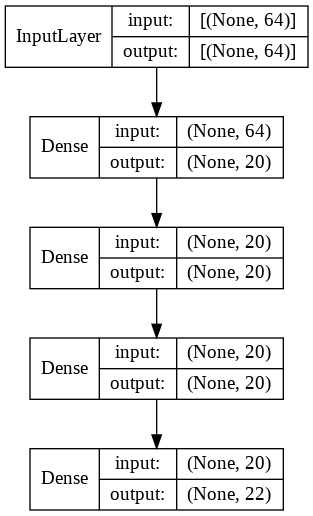

In [20]:
tf.keras.utils.plot_model(ml_model, to_file="model.png", show_shapes=True, expand_nested=True, show_layer_names=False)

Modelo con 2 capas de salidas

In [21]:
def get_compiled_model_2_output():
  inp = tf.keras.layers.Input(shape=(64,))
  l_x = tf.keras.layers.Dense(20, activation='relu', name= 'layer_1')(inp)
  l_x = tf.keras.layers.Dense(20, activation='relu')(l_x)
  
  l_Kingdom = tf.keras.layers.Dense(20, activation='relu', name= 'K_1')(l_x)
  l_Kingdom = tf.keras.layers.Dense(11, activation='softmax', name= 'K_out')(l_Kingdom)
  
  l_DNAtype = tf.keras.layers.Dense(20, activation='relu', name= 'DNA_1')(l_x)
  l_DNAtype = tf.keras.layers.Dense(11, activation='softmax', name= 'DNA_out')(l_DNAtype)

  ml_model = tf.keras.Model(inputs=inp, outputs=[l_Kingdom, l_DNAtype])

  ml_model.compile(optimizer='adam',
                loss='binary_crossentropy',#tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.Accuracy(name='accuracy')])
  return ml_model

In [22]:
x_train, x_test, y_K_train, y_K_test, y_DNA_train, y_DNA_test = train_test_split(X, df_y_1, df_y_2, test_size=0.2, random_state=70)
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_K_train, y_DNA_train))
train_dataset = dataset.shuffle(len(X) + len(df_y_1) + + len(df_y_2), reshuffle_each_iteration=True).batch(1)

In [23]:
ml_model = get_compiled_model_2_output()
#hist = ml_model.fit(x_train, [y_K_train, y_DNA_train], validation_data=(x_test, y_K_test, y_DNA_test), epochs=10)
hist = ml_model.fit(x_train, [y_K_train, y_DNA_train], epochs=10)

Epoch 1/10
326/326 [==============================] - 3s 4ms/step - loss: 0.6224 - K_out_loss: 0.3520 - DNA_out_loss: 0.2703 - K_out_auc: 0.7112 - K_out_accuracy: 0.0000e+00 - DNA_out_auc: 0.9199 - DNA_out_accuracy: 0.0000e+00
Epoch 2/10
326/326 [==============================] - 1s 4ms/step - loss: 0.3082 - K_out_loss: 0.2401 - DNA_out_loss: 0.0682 - K_out_auc: 0.8337 - K_out_accuracy: 0.0000e+00 - DNA_out_auc: 0.9915 - DNA_out_accuracy: 0.0000e+00
Epoch 3/10
326/326 [==============================] - 1s 4ms/step - loss: 0.2532 - K_out_loss: 0.2183 - DNA_out_loss: 0.0349 - K_out_auc: 0.8721 - K_out_accuracy: 0.0000e+00 - DNA_out_auc: 0.9964 - DNA_out_accuracy: 0.0000e+00
Epoch 4/10
326/326 [==============================] - 1s 5ms/step - loss: 0.2362 - K_out_loss: 0.2070 - DNA_out_loss: 0.0292 - K_out_auc: 0.8907 - K_out_accuracy: 0.0000e+00 - DNA_out_auc: 0.9966 - DNA_out_accuracy: 0.0000e+00
Epoch 5/10
326/326 [==============================] - 1s 4ms/step - loss: 0.2177 - K_out_los

In [24]:
tf_prediction = ml_model.predict(x_test)
tf_prediction = tf.cast(tf.greater(tf_prediction, 0.5), tf.int32).numpy()
test_1 = pd.DataFrame(data= tf_prediction[0], columns = df_y_1.columns)#, columns = lb.classes_)
test_2 = pd.DataFrame(data= tf_prediction[1], columns = df_y_2.columns)#, columns = lb.classes_)
test_3 = pd.concat([test_1, test_2], axis=1)
test_3

,arc,bct,inv,mam,phg,plm,pln,pri,rod,vrl,vrt,0,1,2,3,4,5,6,7,9,11,12
0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2601,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0
2602,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2603,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2604,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0


In [25]:
ml_model.evaluate(x_test, [y_K_test, y_DNA_test])

82/82 [==============================] - 1s 4ms/step - loss: 0.1625 - K_out_loss: 0.1480 - DNA_out_loss: 0.0145 - K_out_auc: 0.9473 - K_out_accuracy: 0.0000e+00 - DNA_out_auc: 0.9961 - DNA_out_accuracy: 0.0151


[0.1624811291694641,
 0.14802587032318115,
 0.014455216005444527,
 0.9472809433937073,
 0.0,
 0.996066153049469,
 0.01510500255972147]

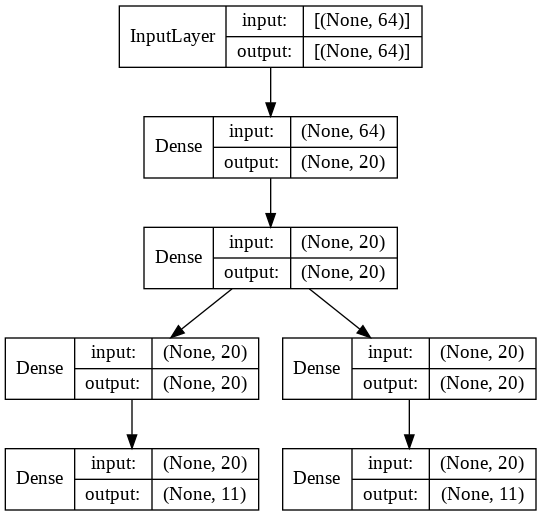

In [26]:
tf.keras.utils.plot_model(ml_model, to_file="model.png", show_shapes=True, expand_nested=True, show_layer_names=False)

##Seleccion de Caracteristicas

###Por Filtrado

In [27]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, mutual_info_classif

In [ ]:
#Implementamos una filtrado usando `mutual_info_classif` no podemos usar chi2 porque tenemos valores negatiivos
filtrado = SelectKBest(mutual_info_classif, k=5).fit(x_train, y_train)

In [ ]:
filtrado.scores_

In [ ]:
X_new = filtrado.transform(x_train)
X_new[:5] #Vemos nuestro set de featuers filtrado

**Implementamos un bucle por cada modelo y vemos los resutlados de usar las k caracteristicas**

####Decision Tree

In [ ]:
max = 0
features = 0
for n in range(66):
  filter = SelectKBest(mutual_info_classif, k=(n+1)).fit(x_train, y_train)
  X_new = filter.transform(x_train)
  Xt_new = filter.transform(Xt)
  dt2 = DecisionTreeClassifier()
  dt2.fit(X_new, y_train)
  acc = dt2.score(Xt_new, Yt)
  f1 = f1_score(Yt, dt2.predict(Xt_new), average='weighted')
  print('Score usando ', (n+1), 'caracteristicas F1:',  f1, ' acurracy: ', acc )
  if f1 > max:
      max = f1
      features = n+1
print('Mejor Score usando ', features, 'caracteristicas F1:',  max)

####Random Forest

In [ ]:
max = 0
features = 0
for n in range(66):
  filter = SelectKBest(mutual_info_classif, k=(n+1)).fit(x_train, y_train)
  X_new = filter.transform(x_train)
  Xt_new = filter.transform(Xt)
  rt2 = RandomForestClassifier(40, n_jobs=-1, oob_score=True)
  rt2.fit(X_new, y_train)
  acc = rt2.score(Xt_new, Yt)
  f1 = f1_score(Yt, rt2.predict(Xt_new), average='weighted')
  print('Score usando ', (n+1), 'caracteristicas F1:',  f1, ' acurracy: ', acc )
  if f1 > max:
      max = f1
      features = n+1
print('Mejor Score usando ', features, 'caracteristicas F1:',  max)

####KNN

In [ ]:
max = 0
features = 0
for n in range(66):
  filter = SelectKBest(mutual_info_classif, k=(n+1)).fit(x_train, y_train)
  X_new = filter.transform(x_train)
  Xt_new = filter.transform(Xt)
  n_neighbors = 4
  knn2 = KNeighborsClassifier(n_neighbors)
  knn2.fit(X_new, y_train)
  acc = knn2.score(Xt_new, Yt)
  f1 = f1_score(Yt, knn2.predict(Xt_new), average='weighted')
  print('Score usando ', (n+1), 'caracteristicas F1:',  f1, ' acurracy: ', acc )
  if f1 > max:
      max = f1
      features = n+1
print('Mejor Score usando ', features, 'caracteristicas F1:',  max)


####XGBoost

In [ ]:
max = 0
features = 0
for n in range(66):
  filter = SelectKBest(mutual_info_classif, k=(n+1)).fit(x_train, y_train)
  X_new = filter.transform(x_train)
  Xt_new = filter.transform(Xt)
  xgb=XGBClassifier(n_estimators=80,  max_depth=10)
  xgb.fit(X_new, y_train)
  acc = xgb.score(Xt_new, Yt)
  f1 = f1_score(Yt, xgb.predict(Xt_new), average='weighted')
  print('Score usando ', (n+1), 'caracteristicas F1:',  f1, ' acurracy: ', acc )
  if f1 > max:
      max = f1
      features = n+1
print('Mejor Score usando ', features, 'caracteristicas F1:',  max)


#### LightGBM

In [ ]:
max = 0
features = 0
for n in range(65):
  filter = SelectKBest(mutual_info_classif, k=(n+1)).fit(x_train, y_train)
  X_new = filter.transform(x_train)
  Xt_new = filter.transform(Xt)
  mdl = lgb.LGBMClassifier(boosting_type='gbdt',objective='binary')
  mdl.fit(X_new, y_train)
  acc = mdl.score(Xt_new, Yt)
  f1 = f1_score(Yt, mdl.predict(Xt_new), average='weighted')
  print('Score usando ', (n+1), 'caracteristicas F1:',  f1, ' acurracy: ', acc )
  if f1 > max:
      max = f1
      features = n+1
print('Mejor Score usando ', features, 'caracteristicas F1:',  max)


####NN

In [ ]:
max = 0
features = 0
lr = 0.01
bs = 256
epochs = 30
X = x_train
Y = y_train
for n in range(66):
  filter = SelectKBest(mutual_info_classif, k=(n+1)).fit(X, Y)
  X_new = filter.transform(X)
  Xt_new = filter.transform(Xt)
  x_train, x_val, y_train, y_val = train_test_split(X_new, Y, test_size=0.2, random_state=42)

  nn2 = Sequential([
      Dense(12, activation='softmax', input_shape=((n+1),))
  ])

  nn2.compile(optimizer=SGD(lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  nn2.fit(x_train, y_train, batch_size=bs, epochs=epochs, validation_data=(x_val, y_val), verbose=0 )
  xt_predict = np.argmax(nn2.predict(Xt_new), axis=1)

  f1 = f1_score(Yt, xt_predict, average='weighted')
  print('Score usando ', (n+1), 'caracteristicas F1:',  f1)
  if f1 > max:
      max = f1
      features = n+1
print('Mejor Score usando ', features, 'caracteristicas F1:',  max)

###Por wrapping - Backward elimination

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

**Apilcamos a cada modelo**

####Decision Tree

In [ ]:
model = DecisionTreeClassifier()
rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(2),scoring='accuracy')
rfecv.fit(X, Y1)
plt.figure()
plt.xlabel("Number of features selected")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [ ]:
rfecv.n_features_

In [ ]:
X_new = rfecv.transform(X)
Xt_new = rfecv.transform(Xt)
dt3 = DecisionTreeClassifier()
dt3.fit(X_new, Y1)
acc = dt3.score(Xt_new, Yt)
f1 = f1_score(Yt, dt3.predict(Xt_new), average='weighted')
print('F1 Score: ', f1)

####Random Forest

In [ ]:
model = RandomForestClassifier(40, n_jobs=-1, oob_score=True)
rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(2),scoring='accuracy')
rfecv.fit(X, Y1)
plt.figure()
plt.xlabel("Number of features selected")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [ ]:
rfecv.n_features_

In [ ]:
X_new = rfecv.transform(X)
Xt_new = rfecv.transform(Xt)
rf3 = RandomForestClassifier(40, n_jobs=-1, oob_score=True)
rf3.fit(X_new, Y1)
acc = rf3.score(Xt_new, Yt)
f1 = f1_score(Yt, rf3.predict(Xt_new), average='weighted')
print('F1 Score: ', f1)

#### XGBoost

In [ ]:
xgb=XGBClassifier(n_estimators=80,  max_depth=10)
rfecv = RFECV(estimator=xgb, step=1, cv=4,scoring='accuracy')
rfecv.fit(X, Y1)
plt.figure()
plt.xlabel("Number of features selected")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [ ]:
rfecv.n_features_

In [ ]:
X_new = rfecv.transform(X)
Xt_new = rfecv.transform(Xt)
xgb = XGBClassifier(n_estimators=80,  max_depth=10)
xgb.fit(X_new, Y1)
acc = xgb.score(Xt_new, Yt)
f1 = f1_score(Yt, xgb.predict(Xt_new), average='weighted')
print('F1 Score: ', f1)

####LightGBM

In [ ]:
model = LGBMClassifier(boosting_type='gbdt',objective='binary')
rfecv = RFECV(estimator=model, step=1, cv=4,scoring='accuracy')
rfecv.fit(X, Y1)
plt.figure()
plt.xlabel("Number of features selected")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [ ]:
rfecv.n_features_

In [ ]:
X_new = rfecv.transform(X)
Xt_new = rfecv.transform(Xt)
model = LGBMClassifier(boosting_type='gbdt',objective='binary')
model.fit(X_new, Y1)
acc = model.score(Xt_new, Yt)
f1 = f1_score(Yt, model.predict(Xt_new), average='weighted')
print('F1 Score: ', f1)

####KNN y Neural Network

KNN no expone la importancia de los features asi que no se puede analizar con RFECV y en las Neural Network tambien es complicado extraer esa informacion

###PCA

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


In [ ]:
pca = PCA().fit(X)
pd.DataFrame(pca.components_, columns=X.columns).head()

In [ ]:
per_var = np.round(pca.explained_variance_ratio_*100, decimals=5)
labels = ['PC' + str(x) for x in range(1, len(per_var) + 1)]
plt.plot(labels, np.cumsum(pca.explained_variance_ratio_), '-s')
#plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
#plt.rcParams['figure.figsize'] = 5, 60
plt.show()

In [ ]:
plt.bar(x=range(1, len(per_var) + 1), height=per_var, tick_label = labels)
#plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
plt.show()

####Decision Tree

In [ ]:
max = 0
components = 0
for n in range(66):
  pca = PCA(n_components=(n+1))
  X_new = pca.fit_transform(X)
  Xt_new = pca.transform(Xt)
  dt4 = DecisionTreeClassifier()
  dt4.fit(X_new, Y1)
  acc = dt4.score(Xt_new, Yt)
  f1 = f1_score(Yt, dt4.predict(Xt_new), average='weighted')
  print('Score usando ', (n+1), 'componentes F1:',  f1, ' acurracy: ', acc )
  if f1 > max:
      max = f1
      components = n+1
print('Mejor Score usando ', components, 'componentes F1:',  max)

####Random Forest

In [ ]:
max = 0
components = 0
for n in range(66):
  pca = PCA(n_components=(n+1))
  X_new = pca.fit_transform(X)
  Xt_new = pca.transform(Xt)
  rf4 = RandomForestClassifier(40, n_jobs=-1, oob_score=True)
  rf4.fit(X_new, Y1)
  acc = rf4.score(Xt_new, Yt)
  f1 = f1_score(Yt, rf4.predict(Xt_new), average='weighted')
  print('Score usando ', (n+1), 'componentes F1:',  f1, ' acurracy: ', acc )
  if f1 > max:
      max = f1
      components = n+1
print('Mejor Score usando ', components, 'componentes F1:',  max)

####XGBoost

In [ ]:
max = 0
components = 0
for n in range(66):
  pca = PCA(n_components=(n+1))
  X_new = pca.fit_transform(X)
  Xt_new = pca.transform(Xt)
  model = XGBClassifier(n_estimators=80,  max_depth=10)
  model.fit(X_new, Y1)
  acc = model.score(Xt_new, Yt)
  f1 = f1_score(Yt, model.predict(Xt_new), average='weighted')
  print('Score usando ', (n+1), 'componentes F1:',  f1, ' acurracy: ', acc )
  if f1 > max:
      max = f1
      components = n+1
print('Mejor Score usando ', components, 'componentes F1:',  max)

####Light GBM

In [ ]:
max = 0
components = 0
for n in range(66):
  pca = PCA(n_components=(n+1))
  X_new = pca.fit_transform(X)
  Xt_new = pca.transform(Xt)
  model = LGBMClassifier(boosting_type='gbdt',objective='binary')
  model.fit(X_new, Y1)
  acc = model.score(Xt_new, Yt)
  f1 = f1_score(Yt, model.predict(Xt_new), average='weighted')
  print('Score usando ', (n+1), 'componentes F1:',  f1, ' acurracy: ', acc )
  if f1 > max:
      max = f1
      components = n+1
print('Mejor Score usando ', components, 'componentes F1:',  max)

####KNN

In [ ]:
max = 0
components = 0
for n in range(66):
  pca = PCA(n_components=(n+1))
  X_new = pca.fit_transform(X)
  Xt_new = pca.transform(Xt)
  knn4 = KNeighborsClassifier(4)
  knn4.fit(X_new, Y1)
  acc = knn4.score(Xt_new, Yt)
  f1 = f1_score(Yt, knn4.predict(Xt_new), average='weighted')
  print('Score usando ', (n+1), 'componentes F1:',  f1, ' acurracy: ', acc )
  if f1 > max:
      max = f1
      components = n+1
print('Mejor Score usando ', components, 'componentes F1:',  max)